# Carregando libs

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from everywhereml.code_generators.tensorflow import tf_porter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Carregando medidas

In [13]:
desligado = pd.read_csv('../medidas/desligado.csv')
potencia1 = pd.read_csv('../medidas/potencia1.csv')
potencia2 = pd.read_csv('../medidas/potencia2.csv')
potencia3 = pd.read_csv('../medidas/potencia3.csv')


desligado = desligado.drop("Unnamed: 0",axis=1)
potencia1 = potencia1.drop("Unnamed: 0",axis=1)
potencia2 = potencia2.drop("Unnamed: 0",axis=1)
potencia3 = potencia3.drop("Unnamed: 0",axis=1)

desligado['time'] = pd.to_datetime(desligado['time'])
potencia1['time'] = pd.to_datetime(potencia1['time'])
potencia2['time'] = pd.to_datetime(potencia2['time'])
potencia3['time'] = pd.to_datetime(potencia3['time'])


desligado['power'] = 'desligado'
potencia1['power'] = 'potencia1'
potencia2['power'] = 'potencia2'
potencia3['power'] = 'potencia3'

full_data = pd.concat([desligado,potencia1,potencia2,potencia3],axis=0)


In [14]:
full_data

,time,ax,ay,az,gx,gy,gz,power
0,2023-12-12 17:44:05.942757,1.707066,-0.059855,9.631873,-0.013590,0.017587,0.012257,desligado
1,2023-12-12 17:44:05.956086,1.707066,-0.043096,9.619903,-0.012790,0.017587,0.012790,desligado
2,2023-12-12 17:44:05.969153,1.719037,-0.031125,9.612720,-0.011458,0.017853,0.013590,desligado
3,2023-12-12 17:44:05.981757,1.738190,-0.016759,9.627085,-0.009859,0.018386,0.014123,desligado
4,2023-12-12 17:44:05.994712,1.745373,0.000000,9.622296,-0.008527,0.018919,0.013856,desligado
...,...,...,...,...,...,...,...,...
6947,2023-12-12 17:53:02.769687,1.893813,0.038307,9.756371,-0.017853,0.019985,0.012524,potencia3
6948,2023-12-12 17:53:02.782714,1.429338,-0.124498,9.655815,-0.006928,0.018386,0.009593,potencia3
6949,2023-12-12 17:53:02.795951,1.879448,0.105345,9.672575,-0.004796,0.015988,0.011991,potencia3
6950,2023-12-12 17:53:02.809002,1.618480,-0.043096,9.536105,-0.020251,0.022916,0.012257,potencia3


In [15]:
full_data['power'].value_counts(1).mul(100).to_frame('%')

,%
power,
potencia2,29.683236
potencia3,27.492387
potencia1,23.980702
desligado,18.843675


Text(0, 0.5, 'Quantidade de medidas')

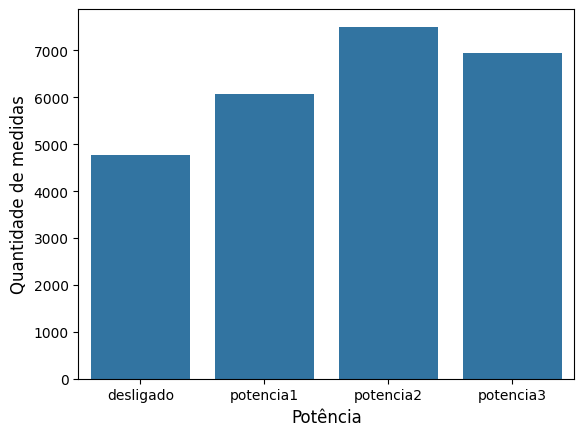

In [16]:
sns.countplot(data=full_data,x='power')
plt.xlabel('Potência',size=12)
plt.ylabel('Quantidade de medidas',size=12)

Text(0, 0.5, 'Aceleração no eixo x')

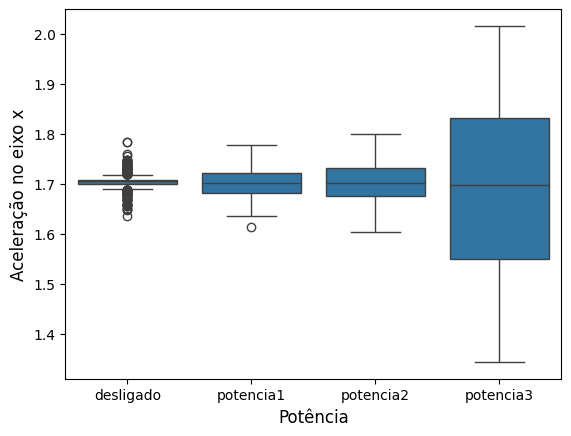

In [17]:
sns.boxplot(data=full_data,x='power',y='ax')
plt.xlabel('Potência',size=12)
plt.ylabel('Aceleração no eixo x',size=12)

In [18]:
desligado = desligado.drop(['time','power'],axis=1)
potencia1 = potencia1.drop(['time','power'],axis=1)
potencia2 = potencia2.drop(['time','power'],axis=1)
potencia3 = potencia3.drop(['time','power'],axis=1)

In [19]:
def feature_extractor(data,windows_len = 10,windows_step=10):

    names_columns = ['ax','ay','az','gx','gy','gz']

    media = data.rolling(window=10,step=10,center=True).mean().dropna()
    media.columns = list(map(lambda x: x+'_mean',media.columns))
    
    desvio = data.rolling(window=10,step=10,center=True).std().dropna()
    desvio.columns = list(map(lambda x: x+'_std',desvio.columns))
    
    maximo = data.rolling(window=10,step=10,center=True).max().dropna()
    maximo.columns = list(map(lambda x: x+'_max',maximo.columns))

    minimo = data.rolling(window=10,step=10,center=True).min().dropna()
    minimo.columns = list(map(lambda x: x+'_min',minimo.columns))

    skw = data.rolling(window=10,step=10,center=True).skew().dropna()
    skw.columns = list(map(lambda x: x+'_skew',skw.columns))

    kt = data.rolling(window=10,step=10,center=True).kurt().dropna()
    kt.columns = list(map(lambda x: x+'_kurt',kt.columns))

    return pd.concat([media,desvio,maximo,minimo],axis=1)                


In [20]:
nmf = feature_extractor(desligado)
nmf['target'] = 0

p1 = feature_extractor(potencia1)
p1['target'] = 1

p2 = feature_extractor(potencia2)
p2['target'] = 2

p3 = feature_extractor(potencia3)
p3['target'] = 3

data = pd.concat([nmf,p1,p2,p3])

In [21]:
data = data.reset_index(drop=True)

In [22]:
data.head()

,ax_mean,ay_mean,az_mean,gx_mean,gy_mean,gz_mean,ax_std,ay_std,az_std,gx_std,...,gx_max,gy_max,gz_max,ax_min,ay_min,az_min,gx_min,gy_min,gz_min,target
0,1.724065,-0.026815,9.649351,-0.009459,0.018945,0.013803,0.009200,0.020403,0.017704,0.002180,...,-0.007727,0.019985,0.014123,1.716643,-0.064643,9.612720,-0.013856,0.017853,0.013323,0
1,1.722868,-0.045729,9.630197,-0.013643,0.017826,0.013563,0.018171,0.010734,0.016894,0.002527,...,-0.009326,0.018386,0.014389,1.697489,-0.064643,9.610326,-0.016254,0.017320,0.012524,0
2,1.723107,-0.024900,9.646478,-0.008633,0.018839,0.013510,0.007823,0.005318,0.010674,0.001503,...,-0.006928,0.019185,0.014123,1.711854,-0.033519,9.629479,-0.011191,0.018386,0.012790,0
3,1.716403,-0.033998,9.652703,-0.013083,0.017320,0.013057,0.005805,0.013997,0.005178,0.000789,...,-0.011991,0.018119,0.013323,1.709460,-0.052672,9.641450,-0.014123,0.016787,0.012790,0
4,1.717361,-0.048602,9.638338,-0.010579,0.018759,0.013376,0.007231,0.007575,0.005419,0.001559,...,-0.008260,0.019718,0.013856,1.707066,-0.057461,9.629479,-0.012790,0.017054,0.013057,0


In [30]:
X = data.drop('target',axis=1)
y = data['target']


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4,stratify = y, random_state= 42)
X_train.shape,X_test.shape

((1515, 24), (1010, 24))

# Modelando a rede neural

In [76]:
def gerar_modelo(n_neurons, n_neurons2):

    inputs = layers.Input(shape=(24))

    # first layer
    x = layers.BatchNormalization()(inputs)
    x= layers.Dense(n_neurons,activation='relu')(x)

    # second layer
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(n_neurons2,activation='relu')(x)

    ## third layer
    #x = layers.BatchNormalization()(x)
    #x = layers.Dropout(0.3)(x)
    #x = layers.Dense(50,activation='relu')(x)

    ## fourth layer
    #x = layers.BatchNormalization()(x)
    #x = layers.Dropout(0.3)(x)
    #x = layers.Dense(25,activation='relu')(x)

    ## fifth layer
    #x = layers.BatchNormalization()(x)
    #x = layers.Dropout(0.3)(x)
    #x = layers.Dense(10,activation='relu')(x)

    #output layer
    outputs = layers.Dense(4,activation='softmax')(x)

    model = keras.Model(inputs = inputs, outputs = outputs)
    model.summary()
    return model

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 24)]              0         
                                                                 
 batch_normalization_46 (Ba  (None, 24)                96        
 tchNormalization)                                               
                                                                 
 dense_69 (Dense)            (None, 8)                 200       
                                                                 
 dropout_23 (Dropout)        (None, 8)                 0         
                                                                 
 batch_normalization_47 (Ba  (None, 8)                 32        
 tchNormalization)                                               
                                                                 
 dense_70 (Dense)            (None, 6)                 54 

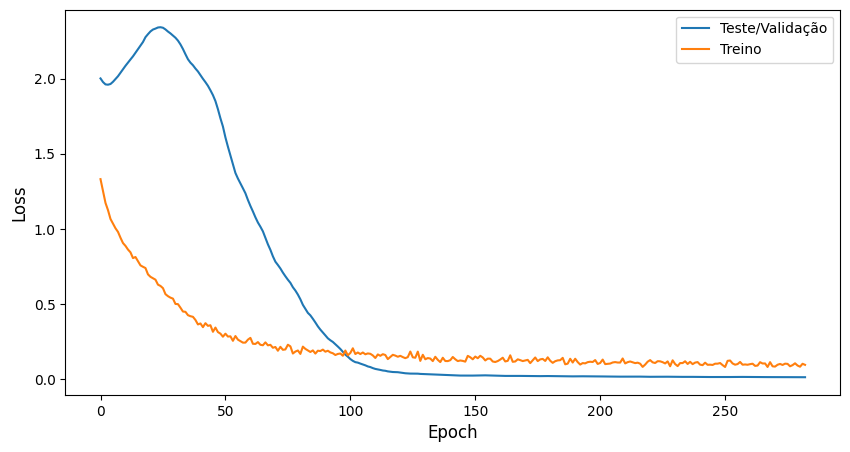

In [83]:
model = gerar_modelo(8,6)

early_stopping = EarlyStopping(
        min_delta=0.5, # minimium amount of change to count as an improvement
        patience=200, # how many epochs to wait before stopping
        restore_best_weights=True)


model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['acc'])
history = model.fit(x=X_train, y=y_train, batch_size=256, epochs=10000,shuffle=True,verbose=0 ,validation_data=(X_test, y_test),callbacks=[early_stopping])

epoch = [i for i in range(len(history.history['val_loss']))]


plt.figure(figsize=(10,5))
plt.plot(epoch,history.history['val_loss'],label='Teste/Validação')
plt.plot(epoch,history.history['loss'],label='Treino')
plt.xlabel('Epoch',size=12)
plt.ylabel('Loss',size=12)
plt.legend()

# Exportanto o código em c++

In [ ]:
porter = tf_porter(model, X_train, y_train)
cpp_code = porter.to_cpp(instance_name='model', arena_size=4096)

2023-11-28 23:52:47.271099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,200]
	 [[{{node inputs}}]]
2023-11-28 23:52:47.286054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100]
	 [[{{node inputs}}]]
2023-11-28 23:52:47.300171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,50]
	 [[{{node inputs}}]]
2023-11-28 23:52:

INFO:tensorflow:Assets written to: /tmp/tmpe4h_so2x/assets


INFO:tensorflow:Assets written to: /tmp/tmpe4h_so2x/assets
2023-11-28 23:52:50.093979: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-11-28 23:52:50.094005: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-11-28 23:52:50.095536: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpe4h_so2x
2023-11-28 23:52:50.099057: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-11-28 23:52:50.099112: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpe4h_so2x
2023-11-28 23:52:50.115803: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-11-28 23:52:50.231860: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmpe4h_so2x
2023-11-28 23:52:50.262621: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

In [ ]:
print(cpp_code)

#ifndef UUID140302518848576
#define UUID140302518848576

#include <EloquentTinyML.h>
#include <eloquent_tinyml/tensorflow.h>

#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

#ifndef ARENA_SIZE
#define ARENA_SIZE 4096
#endif

/** model size = 131428 bytes **/
const unsigned char modelData[] DATA_ALIGN_ATTRIBUTE = { 0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x90, 0x00, 0x00, 0x00, 0xe8, 0x00, 0x00, 0x00, 0x38, 0xf2, 0x01, 0x00, 0x48, 0xf2, 0x01, 0x00, 0x00, 0x01, 0x02, 0x00, 0x03, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00, 0x10, 0x00, 0x0c,